# Build Model ANN

### **Import Libraries**

In [123]:
# library dataframe
import pandas as pd
# library olah data numerical
import numpy as np

# Data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# libraries Data Preprocessing
from sklearn.model_selection import train_test_split # splitting data
from feature_engine.outliers import Winsorizer # outlier
from sklearn.preprocessing import StandardScaler # scalling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # encoder
from sklearn.impute import SimpleImputer # imputer missing value

# sampling
from imblearn.over_sampling import SMOTE # over-sample

# Pipeline
from sklearn.pipeline import Pipeline # pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # pipeline balanced data
from sklearn.compose import ColumnTransformer

# Evaluasi model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ----------------------------------------------#
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# tuning model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# Save model
import joblib
import json
import os

# utils
from collections import Counter
from pprint import pprint as pprint

# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings('ignore')

In [252]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout,  BatchNormalization
from keras.initializers import HeNormal, GlorotUniform
from keras.regularizers import l2


print(tf.__version__)

2.13.0


## Load Data

In [224]:
data = pd.read_csv('data/bank_marketing.csv', sep=';', na_values='unknown')

data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Data cleaning

In [225]:
# hapus data duplikat yang terakhir
data.drop_duplicates(keep='first', inplace=True)

In [226]:
# Ubah nama kolom
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns = data.columns.str.replace('.', '_')

In [227]:
# Ubah 'duration' ke menit
data['duration'] = data['duration'] / 60  # Mengubah detik ke menit

In [228]:
# ubah pdays '999' jadi '0' mengacu kepada customer yang belum di hubungi
data['pdays'] = data['pdays'].replace(999, 0)

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             40846 non-null  object 
 2   marital         41096 non-null  object 
 3   education       39446 non-null  object 
 4   default         32580 non-null  object 
 5   housing         40186 non-null  object 
 6   loan            40186 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  float64
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp_var_rate    41176 non-null  float64
 16  cons_price_idx  41176 non-null  float64
 17  cons_conf_idx   41176 non-null  floa

# Feature Engineering

### Spliting Data

In [230]:
# split feature and label
X = data.drop('y', axis=1)
y = data['y'].map({'no':0, 'yes':1})

In [231]:
seed = 42
np.random.seed(seed)

# Split train-validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed)
# Split tran and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=seed)

In [232]:
print('Shape X_train:', X_train.shape)
print('Shape y_train:', y_train.shape)

print('Shape X_test:', X_test.shape)
print('Shape y_test:', y_test.shape)

print('Shape X_val:', X_val.shape)
print('Shape y_val:', y_val.shape)

Shape X_train: (29749, 20)
Shape y_train: (29749,)
Shape X_test: (6177, 20)
Shape y_test: (6177,)
Shape X_val: (5250, 20)
Shape y_val: (5250,)


### Missing value checking

In [233]:
## kita tau data "unknown" adalah missing value MCAR
# buat data "unknown" ke nan agar terbaca oleh pandas
X_train.replace("unknown",np.nan,inplace=True)
X_test.replace("unknown",np.nan,inplace=True)
X_val.replace("unknown",np.nan,inplace=True)

In [234]:
X_train.isna().sum()

age                  0
job                244
marital             63
education         1273
default           6163
housing            711
loan               711
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
dtype: int64

### Handling outlier

In [235]:
# handling outlier
def handling_outlier_wisorized(X_train, X_test, X_val,cols_outlier):
  #cek data normal dan tidak normal
  list_cols_normal = []
  list_cols_Not_normal = []

  for col in X[cols_outlier]:

    skew = X_train[col].skew()
    kurtosis = X_train[col].kurt()

    if -0.5 < skew < 0.5 or kurtosis < 3:
      list_cols_normal.append(col)
      
    else:
      list_cols_Not_normal.append(col)

  # handling outlier
  winsorizer_normal_dist = Winsorizer(capping_method='gaussian',
                                      tail='both',
                                      fold=3,
                                      variables=list_cols_normal,
                                      missing_values='ignore')

  winsorizer_not_normal_dist = Winsorizer(capping_method='iqr',
                                 tail='both',
                                 fold=1.5,
                                 variables=list_cols_Not_normal,
                                 missing_values='ignore')

  X_train_capped = winsorizer_normal_dist.fit_transform(X_train)
  X_test_capped = winsorizer_normal_dist.transform(X_test)
  X_val_capped = winsorizer_normal_dist.transform(X_val)


  X_train_capped = winsorizer_not_normal_dist.fit_transform(X_train_capped)
  X_test_capped = winsorizer_not_normal_dist.transform(X_test_capped)
  X_val_capped = winsorizer_not_normal_dist.transform(X_val_capped)

  return X_train_capped, X_test_capped, X_val_capped


In [236]:
# handling outlier
cols_outlier = ['age',
 'duration',
 'campaign',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']


X_train_capped, X_test_capped, X_val_capped = handling_outlier_wisorized(X_train, X_test, X_val,cols_outlier)

In [237]:
# Plot Distribution Comparison
def outlier_handling_plot_comparison(df_before, df_after, variable):
    """
    This function is created to plot histograms and boxplots for a variable before and after outlier handling

    Parameters:
    - df_before (pandas.DataFrame): DataFrame before outlier handling
    - df_after (pandas.DataFrame): DataFrame after outlier handling
    - variable (str): The variable to plot

    Example:
    num_cols = ['numeric_column']                                   <- Enter the numeric column
    for col in num_cols:                                            <- make a for loop in numeric column to access every columns
        plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

    """
    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

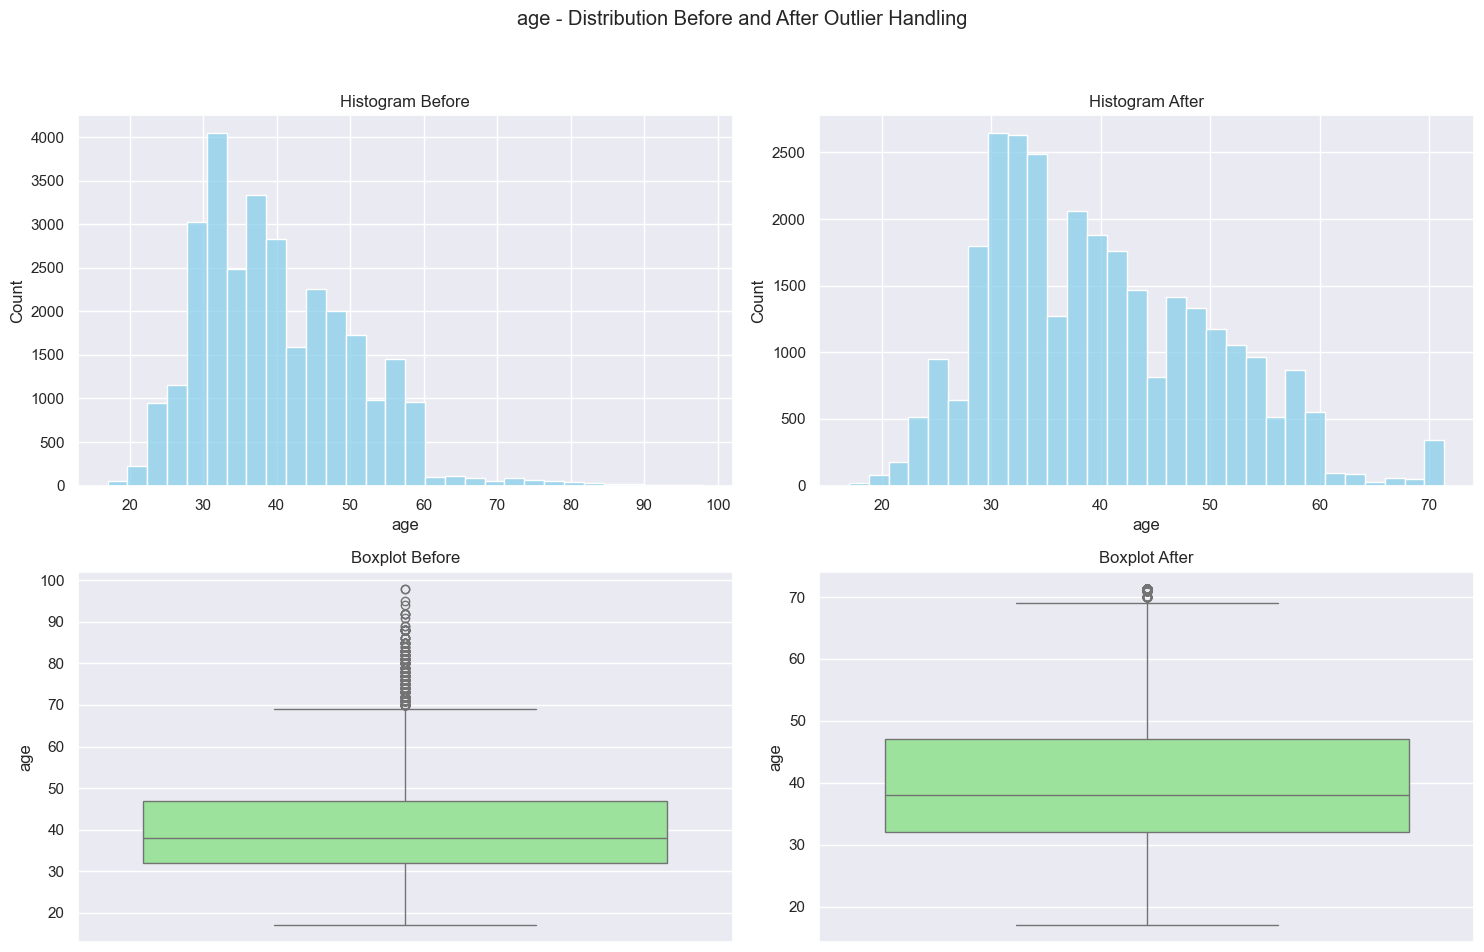

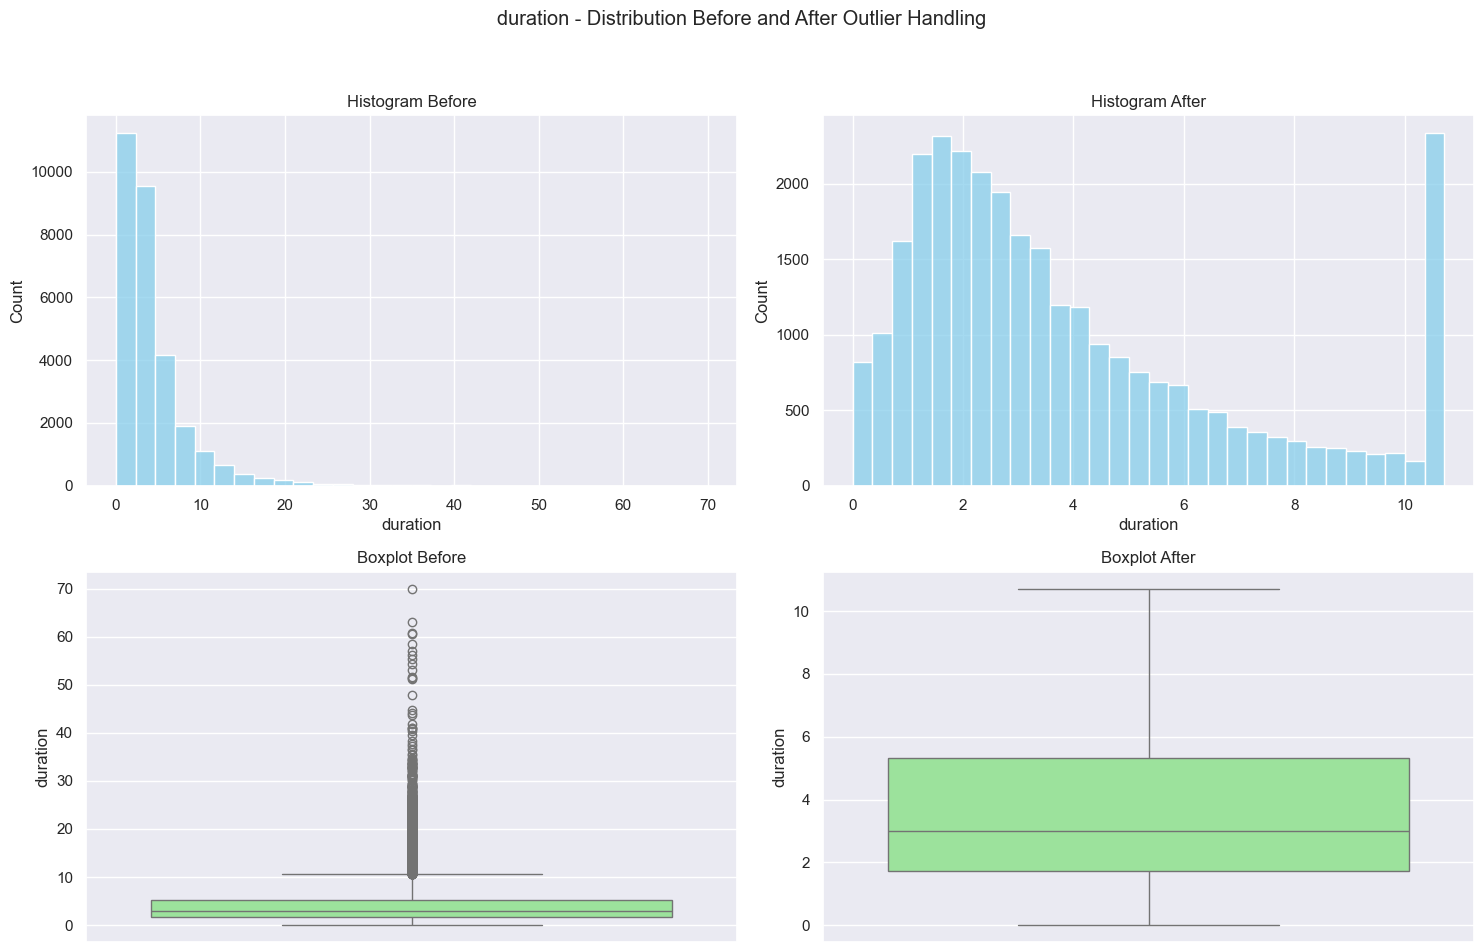

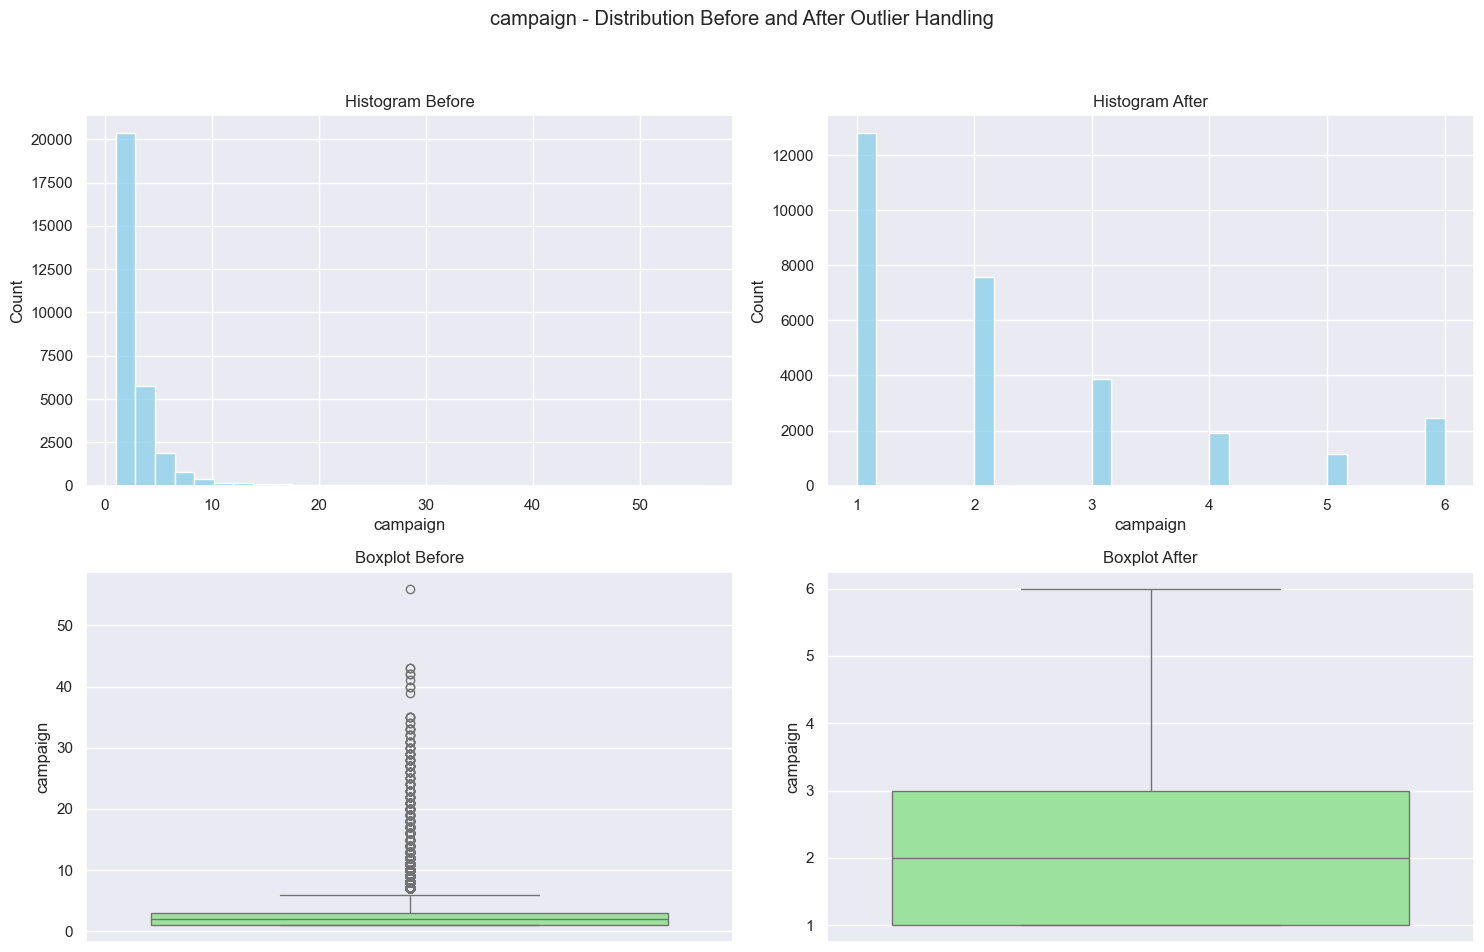

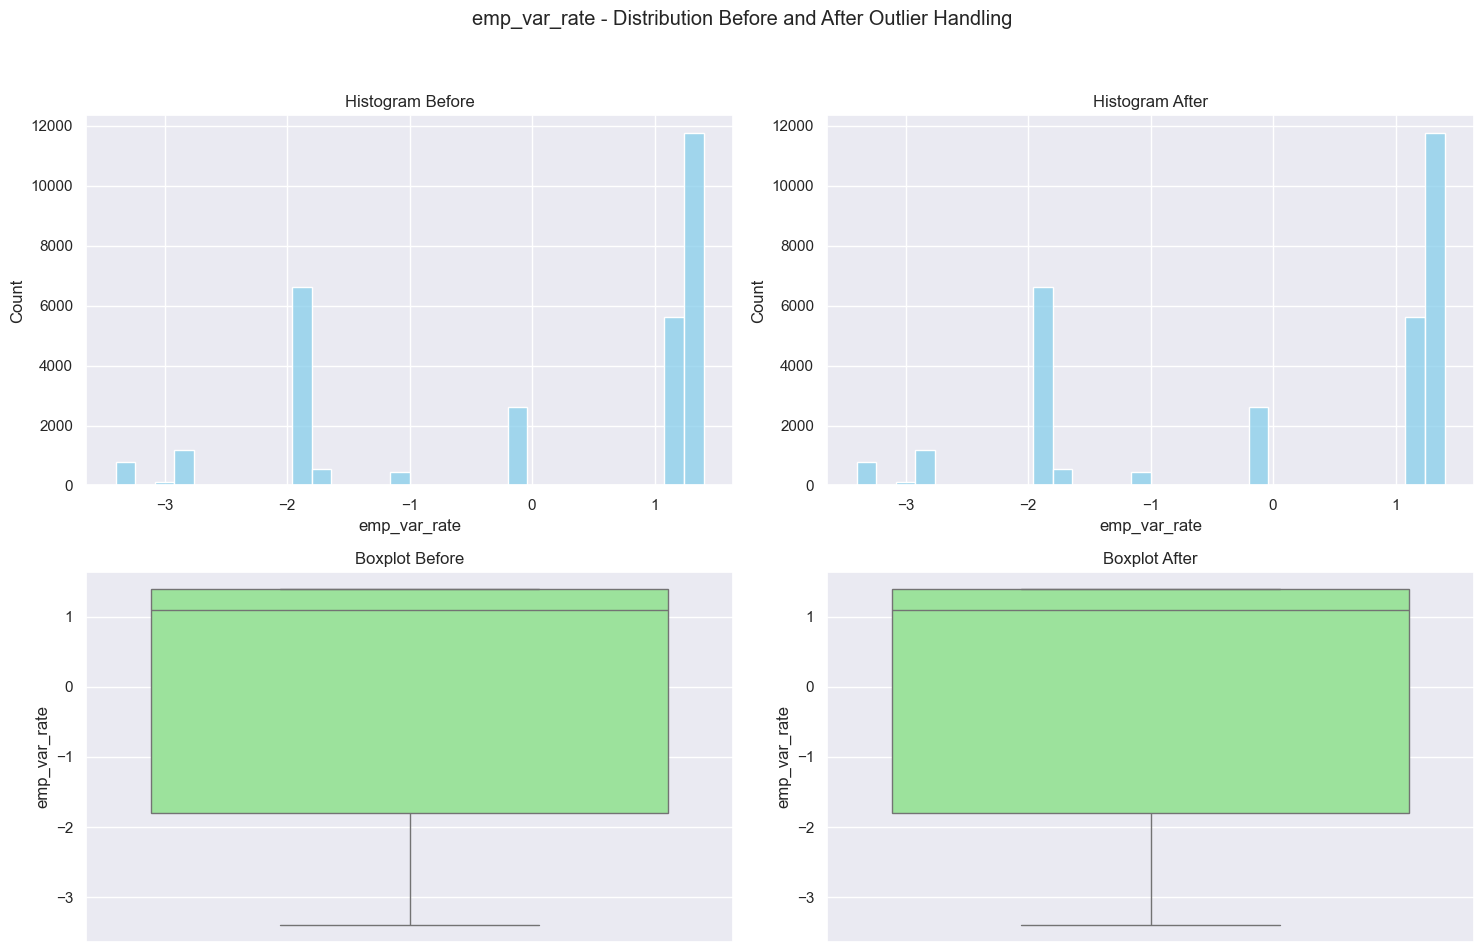

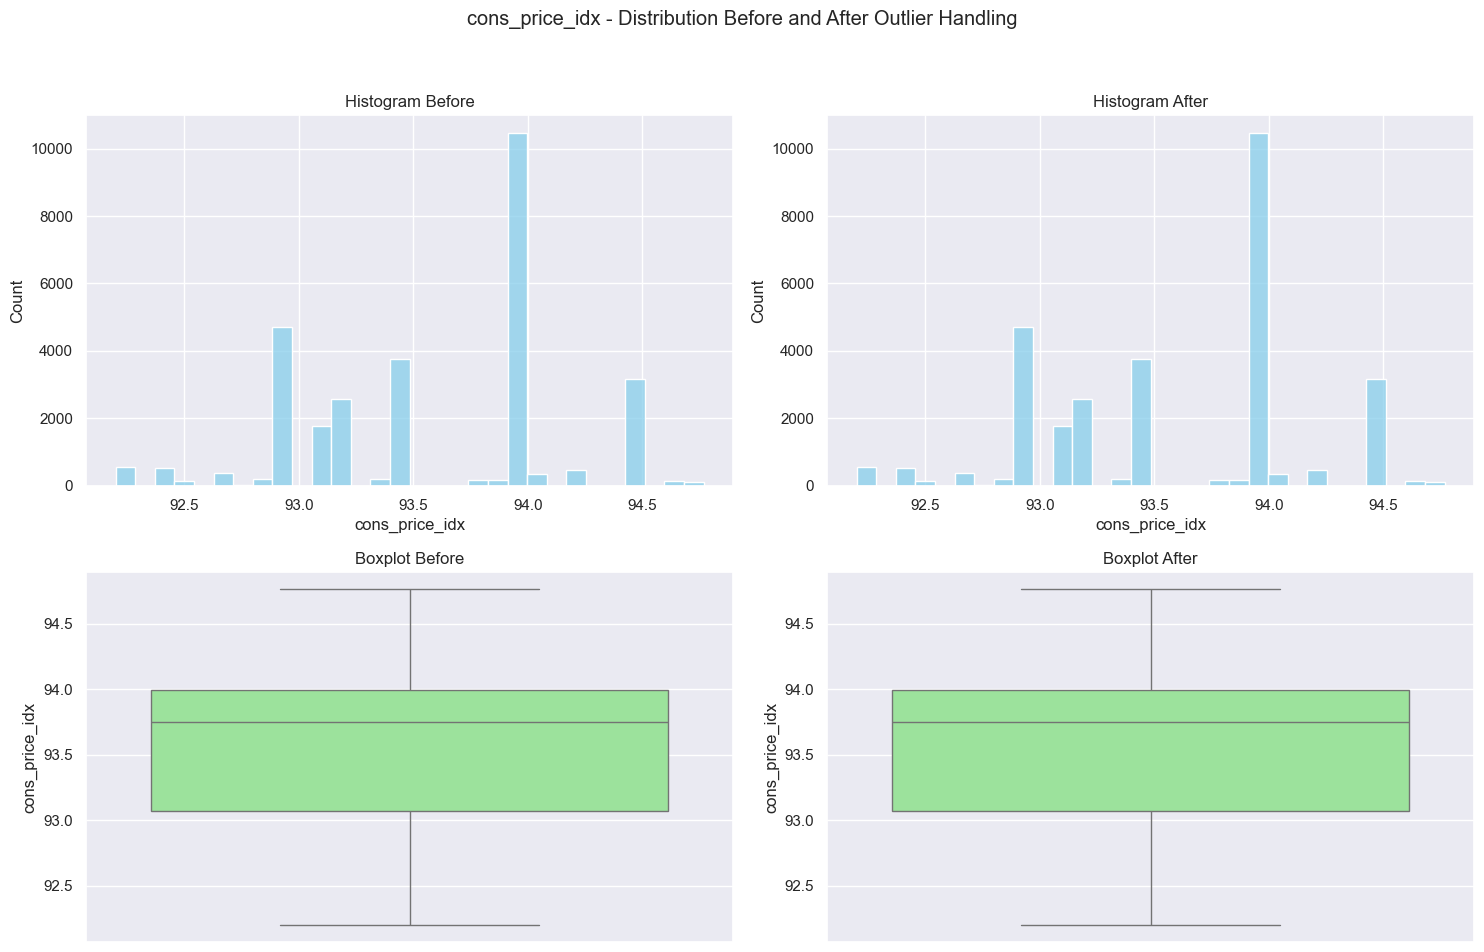

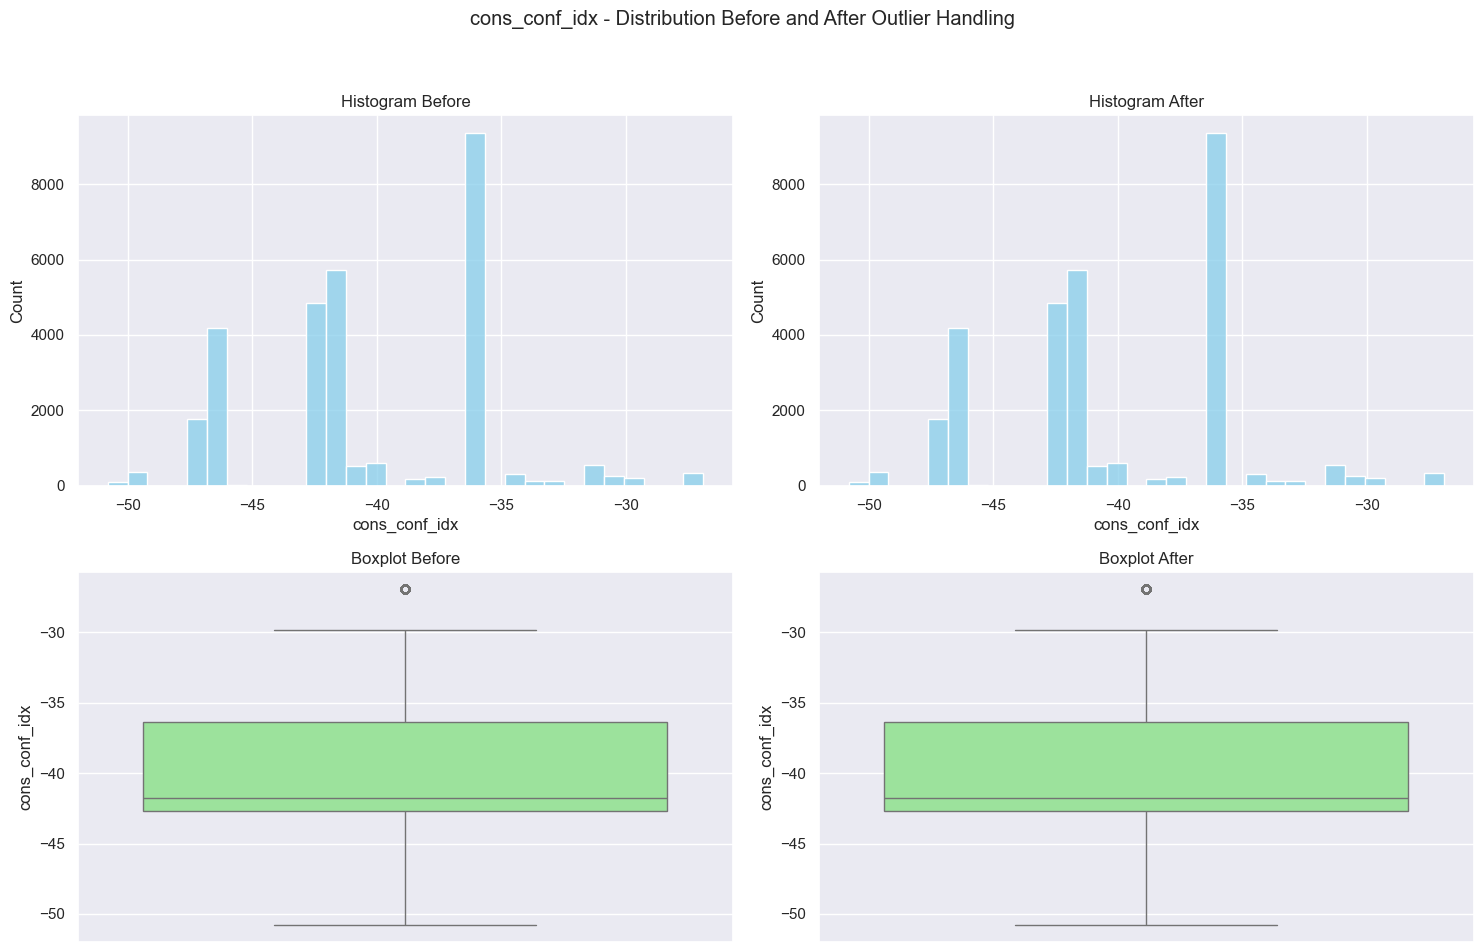

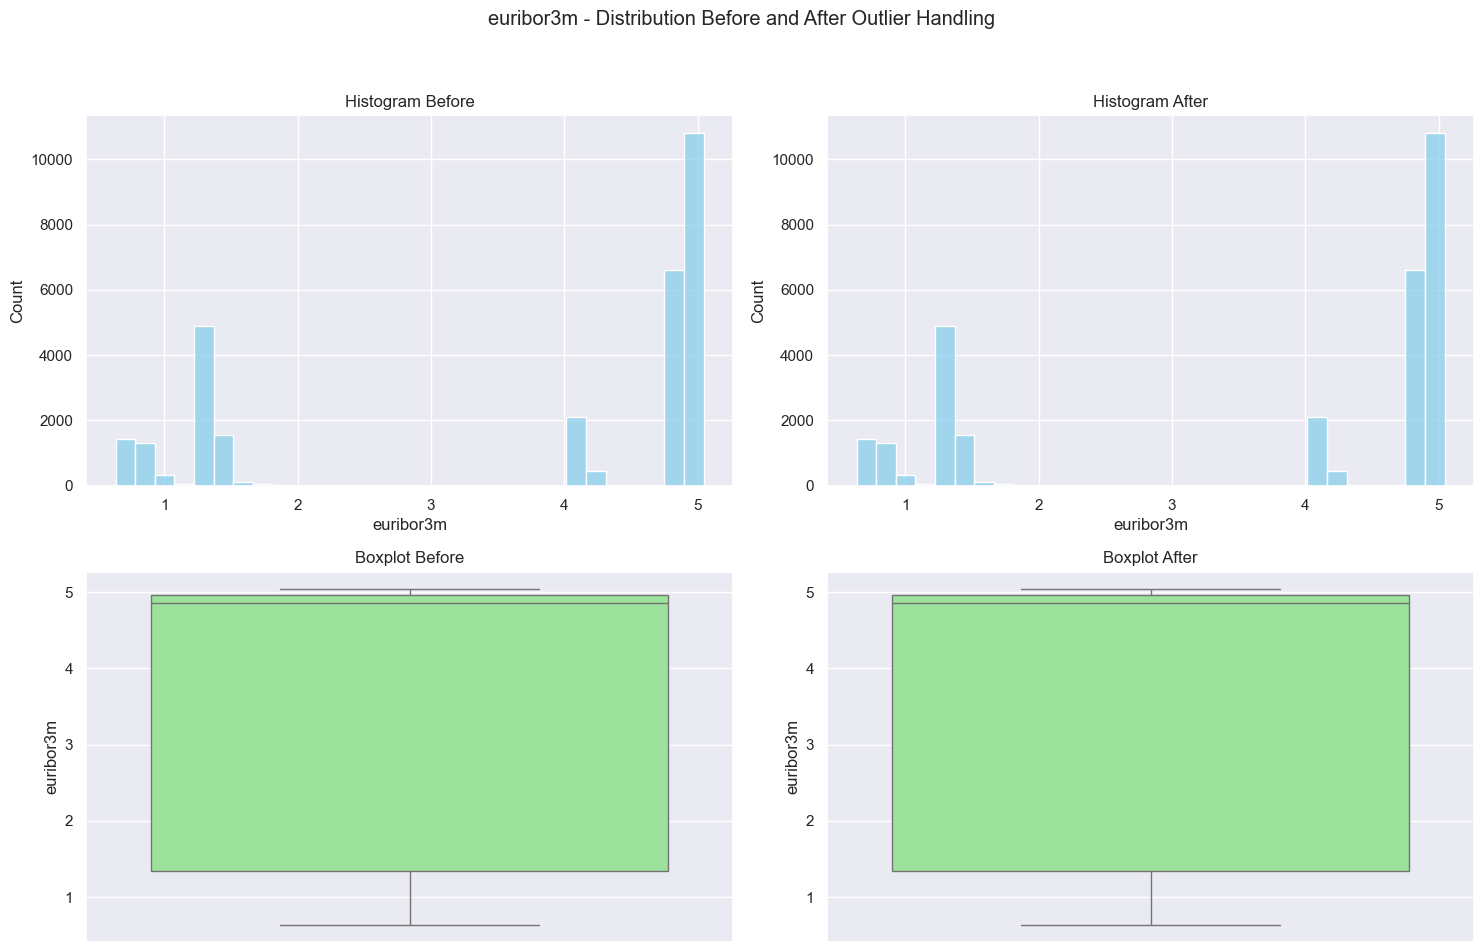

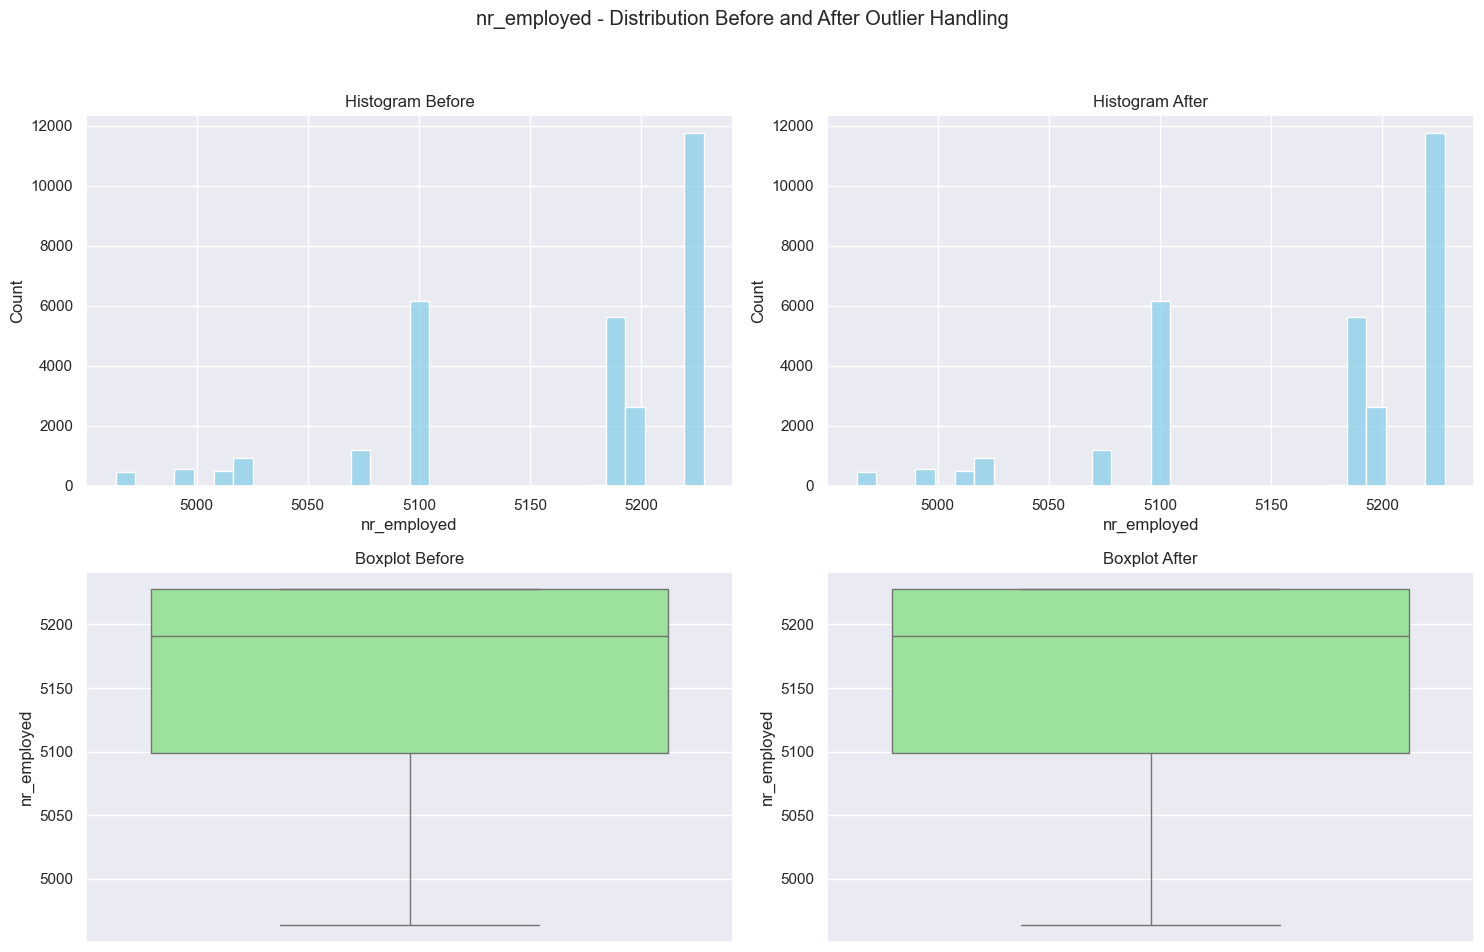

In [238]:
# Using the Function
for col in cols_outlier:
    outlier_handling_plot_comparison(X_train, X_train_capped, col)

### Feature selection 

In [239]:
# base feature from feature importence
list_feature_importence = ['duration', 
                           'nr_employed', 
                           'emp_var_rate', 
                           'euribor3m', 
                           'pdays', 
                           'cons_price_idx', 
                           'cons_conf_idx', 
                           'contact', 
                           'poutcome', 
                           'month', 
                           'day_of_week', 
                           'age']
# apply feature importence
X_train_selected = X_train_capped[list_feature_importence]
X_val_selected = X_val_capped[list_feature_importence]
X_test_selected = X_test_capped[list_feature_importence]

print(f"Train set : {X_train_selected.shape}")
print(f"Validation set : {X_val_selected.shape}")
print(f"Test set : {X_test_selected.shape}")

Train set : (29749, 12)
Validation set : (5250, 12)
Test set : (6177, 12)


In [240]:
X_train_selected.head()

,duration,nr_employed,emp_var_rate,euribor3m,pdays,cons_price_idx,cons_conf_idx,contact,poutcome,month,day_of_week,age
11162,2.816667,5228.1,1.4,4.961,0,94.465,-41.8,telephone,nonexistent,jun,thu,51.0
34634,2.633333,5099.1,-1.8,1.266,0,92.893,-46.2,cellular,nonexistent,may,thu,39.0
13639,1.133333,5228.1,1.4,4.963,0,93.918,-42.7,cellular,nonexistent,jul,thu,25.0
28234,2.416667,5099.1,-1.8,1.453,0,93.075,-47.1,cellular,nonexistent,apr,tue,40.0
37603,3.100000,5076.2,-2.9,0.861,0,92.201,-31.4,cellular,nonexistent,aug,mon,67.0


In [241]:
X_val_selected.head()

,duration,nr_employed,emp_var_rate,euribor3m,pdays,cons_price_idx,cons_conf_idx,contact,poutcome,month,day_of_week,age
22694,2.666667,5228.1,1.4,4.964,0,93.444,-36.1,cellular,nonexistent,aug,fri,32.0
12442,7.683333,5228.1,1.4,4.960,0,93.918,-42.7,cellular,nonexistent,jul,mon,42.0
5606,6.316667,5191.0,1.1,4.857,0,93.994,-36.4,telephone,nonexistent,may,mon,56.0
13770,2.850000,5228.1,1.4,4.963,0,93.918,-42.7,cellular,nonexistent,jul,thu,37.0
36239,3.533333,5076.2,-2.9,1.266,0,92.963,-40.8,cellular,nonexistent,jun,mon,52.0


In [242]:
X_test_selected.head()

,duration,nr_employed,emp_var_rate,euribor3m,pdays,cons_price_idx,cons_conf_idx,contact,poutcome,month,day_of_week,age
7289,10.716667,5191.0,1.1,4.860,0,93.994,-36.4,telephone,nonexistent,may,thu,58.0
8040,2.850000,5228.1,1.4,4.865,0,94.465,-41.8,telephone,nonexistent,jun,mon,36.0
4717,10.683333,5191.0,1.1,4.858,0,93.994,-36.4,telephone,nonexistent,may,wed,33.0
29256,5.550000,5099.1,-1.8,1.405,0,93.075,-47.1,cellular,nonexistent,apr,fri,34.0
27496,10.716667,5195.8,-0.1,4.021,0,93.200,-42.0,cellular,nonexistent,nov,fri,49.0


### Preprocessing data

In [243]:
numeric_feature = X_train_selected.select_dtypes(include=np.number).columns.to_list()

In [244]:
category_feature = X_train_selected.select_dtypes(include=['object', 'category']).columns.to_list()

In [245]:
for col in category_feature:
    print(f"{col} : {X_train_selected[col].unique()}")

contact : ['telephone' 'cellular']
poutcome : ['nonexistent' 'failure' 'success']
month : ['jun' 'may' 'jul' 'apr' 'aug' 'nov' 'oct' 'sep' 'dec' 'mar']
day_of_week : ['thu' 'tue' 'mon' 'fri' 'wed']


In [246]:
# ordinal data
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_of_week_order = ['mon', 'tue', 'wed', 'thu', 'fri']
ord_feature = ['month', 'day_of_week']

# nominal data
ohe_feature = ['contact', 'poutcome']

num_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

ord_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord_enc", OrdinalEncoder(categories=[month_order, day_of_week_order]))
])

ohe_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot_enc", OneHotEncoder(handle_unknown='ignore',sparse=False))
])

# column transformer

preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_transform, numeric_feature),
          ('ordinal', ord_transform, ord_feature),
          ('onehot', ohe_transform, ohe_feature)
        ])

In [247]:
preprocessor_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE())
])

In [248]:
preprocessor_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'nr_employed',
                                                   'emp_var_rate', 'euribor3m',
                                                   'pdays', 'cons_price_idx',
                                                   'cons_conf_idx', 'age']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(categories=[['mar',
                                                                                               'apr',
                                                                                               'may',
                                                                                               'jun',
                                                                                               'jul',
                                                                                               'aug',
                                                                                               'sep',
                                                                                               'oct',
                                                                                               'nov',
                                                                                               'dec'],
                                                                                              ['mon',
                                                                                               'tue',
                                                                                               'wed',
                                                                                               'thu',
                                                                                               'fri']]))]),
                                                  ['month', 'day_of_week']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['contact', 'poutcome'])])),
                ('oversample', SMOTE())])

In [249]:
X_train_preproc = preprocessor.fit_transform(X_train_selected)
X_val_preproc = preprocessor.transform(X_val_selected)
X_test_preproc = preprocessor.transform(X_test_selected)

### Balancing data

In [250]:
seed = 12
np.random.seed(seed)
smote = SMOTE(random_state=seed)

# imbalance handling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preproc, y_train)
print("Label class: {}".format(Counter(y_train_resampled)))


Label class: Counter({0: 26397, 1: 26397})


# Build Model

In [272]:
# parameter

input_shape = X_train_resampled.shape[1]

n_batch_size = 32

n_steps_per_epoch = int(X_train_preproc.shape[0] / n_batch_size)
n_validation_steps = int(X_val_preproc.shape[0] / n_batch_size)
n_test_steps = int(X_test_preproc.shape[0]/ n_batch_size)

n_epochs = 50

print("Input shape : {}".format(input_shape))
print("Batch size : {}".format(n_batch_size))
print("\nSteps per epoch : {}".format(n_steps_per_epoch))
print("\nValidation steps : {}".format(n_validation_steps))
print("Test steps : {}".format(n_test_steps))
print("\nNumber per Epochs : {}".format(n_epochs))


Input shape : 15
Batch size : 32

Steps per epoch : 929

Validation steps : 164
Test steps : 193

Number per Epochs : 50


In [273]:
# clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define model
model = Sequential()
model.add(Dense(16, activation='relu', kernel_initializer=HeNormal(seed), input_shape=(input_shape, )))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_initializer=HeNormal(seed)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed)))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                192       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                416       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [274]:
PATH_DIR = "./model_and_param/model_checkpoint"
if not os.path.exists(PATH_DIR):
    os.makedirs(PATH_DIR)


def get_unique_filename(directory, base_filename, extension):
    counter = 1
    filename = f"{base_filename}.{extension}"
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base_filename}_{counter}.{extension}"
        counter += 1
    return filename


file_name = get_unique_filename(PATH_DIR, "model_ann", "h5")
# callbacks
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(PATH_DIR, file_name),
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True  # Hanya menyimpan model jika ada perbaikan pada val_loss
)
# early stoping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [275]:
# Training model
history = model.fit(X_train_resampled, 
                    y_train_resampled,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(X_val_preproc, y_val),
                    validation_steps=n_validation_steps,
                    callbacks=[model_checkpoint])

Epoch 1/50
928/929 [============================>.] - ETA: 0s - loss: 0.6045 - accuracy: 0.7354
Epoch 1: val_accuracy improved from -inf to 0.83060, saving model to ./model_and_param/model_checkpoint\model_ann_6.h5
929/929 [==============================] - 8s 5ms/step - loss: 0.6043 - accuracy: 0.7355 - val_loss: 0.3776 - val_accuracy: 0.8306
Epoch 2/50
926/929 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.8245
Epoch 2: val_accuracy improved from 0.83060 to 0.84146, saving model to ./model_and_param/model_checkpoint\model_ann_6.h5
929/929 [==============================] - 4s 5ms/step - loss: 0.4487 - accuracy: 0.8245 - val_loss: 0.3266 - val_accuracy: 0.8415
Epoch 3/50
925/929 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8364
Epoch 3: val_accuracy did not improve from 0.84146
929/929 [==============================] - 4s 5ms/step - loss: 0.4230 - accuracy: 0.8365 - val_loss: 0.3458 - val_accuracy: 0.8302
Epoch 4/50
923/929 [=======

In [276]:
# Evaluate
hist_df = pd.DataFrame(history.history)


In [277]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.604283,0.735502,0.377643,0.830602
1,0.448730,0.824473,0.326622,0.841463
2,0.423043,0.836450,0.345812,0.830221
3,0.404632,0.849102,0.301363,0.853087
4,0.395183,0.852025,0.294735,0.852896
5,0.397347,0.850515,0.288902,0.852896
6,0.388408,0.854884,0.265999,0.858041
7,0.387601,0.852365,0.268563,0.856517
8,0.378292,0.856907,0.279186,0.849276
9,0.378324,0.857037,0.243855,0.875762


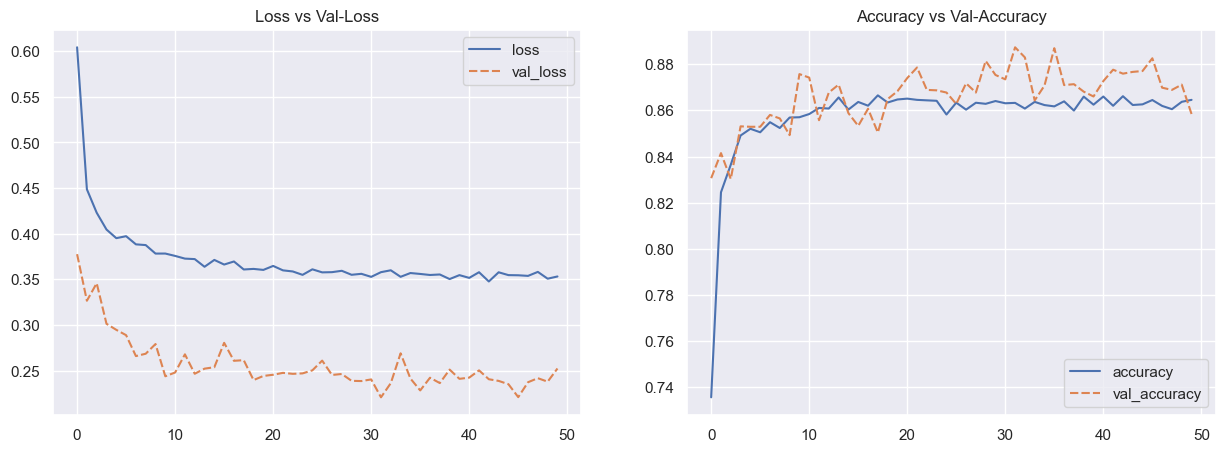

In [278]:
# Plot Training Results

history_1_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_1_df[['loss', 'val_loss']])
plt.grid(True)
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_1_df[['accuracy', 'val_accuracy']])
plt.grid(True)
plt.title('Accuracy vs Val-Accuracy')
plt.show()